# Run FSL Palm

### Authors: Calvin Howard, Alexander Cohen, Christopher Lin, William Drew.

#### Last updated: July 6, 2023

Use this to run/test a statistical model (e.g., regression or T-tests) on lesion network maps (or lesions alone!) using PALM, potentially taking into account specific covariates of interest and/or nuisance regressors.

Notes:
- To best use this notebook, you should be familar with GLM design and Contrast Matrix design. See this webpage to get started:
[FSL's GLM page](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM)
- This notebook is a combination of the old PALM Notebooks and Christopher's palm_analysis notebooks (does the same thing) and requires the NIMLAB Python 3 environment as a kernel. Directions are on the [NIMLAB software_env README.md](https://github.com/nimlab/software_env)
- You will need a csv file that provides the paths to your fcMaps, usually created from the [Preprocessing](https://github.com/nimlab/templates/blob/master/py3_notebooks/1_Preprocessing_LesionQA_fcSurfBcbLqtGen_nimtrack.ipynb) notebook.
- Christopher wrote up a really nice description of how to modify code to set up your design matrix within the notebook here: [PALM-Analysis](https://github.com/nimlab/documentation/wiki/PALM-experimental-designs)
- I would also recommend reviewing Fred's [slides](https://github.com/nimlab/documentation/blob/master/presentations/presentation_palm_multidataset_analyses_labmeeting_13.4.2020.pdf) from his May 2020 lab meeting For details regarding the difference between implementing a random effects and fixed effects analysis and use of exchangeability blocks

In [1]:
## Packages and environmental settings:

##Packages:
import os
import sys
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from nimlab import software as sf
from nimlab import datasets as nimds
from nilearn import image, plotting

MNI_brain_mask = nimds.get_img("MNI152_T1_2mm_brain_mask")

%matplotlib inline

In [2]:
def process_nifti_paths(csv_file_path):
    # Load the required packages
    import pandas as pd
    import re
    pd.set_option('display.max_columns', None)
    pd.set_option('max_colwidth', None)

    # Function to extract subject ID from the file path
    def extract_subject_id(file_path):
        # Extract 'subject' or 'sub-' and the associated number from the total path
        match = re.search(r'(subject\d+|sub-\d+)', file_path)
        if match:
            # If found, remove non-numeric characters and return the numeric part
            return ''.join(filter(str.isdigit, match.group()))
        
        # If 'subject' or 'sub-' is not found in the total path, extract the basename and find the number in it
        else:
            # Extract the file name from the file path
            file_name = file_path.split('/')[-1]

            # Extract the first number from the file name
            match = re.search(r'\d+', file_name)
            if match:
                return match.group()
            else:
                return pd.np.nan

    # Load the data
    nifti_paths = pd.read_csv(csv_file_path, header=None, names=['nifti_path'])

    # Apply the function to the 'nifti_path' column
    nifti_paths['subject_id'] = nifti_paths['nifti_path'].apply(extract_subject_id)

    # Extract the list of nifti file paths
    nifti_file_paths = nifti_paths['nifti_path'].tolist()

    return nifti_file_paths, nifti_paths

In [3]:
import pandas as pd

def remove_column_spaces(df):
    # Making a copy of the DataFrame
    processed_df = df.copy()
    # Replacing spaces with underscores in column names
    processed_df.columns = [col.replace(" ", "_") for col in processed_df.columns]
    return processed_df

def add_prefix_to_numeric_cols(data_df, prefix='var_'):
    """
    This function renames columns that start with a number by adding a prefix.

    Parameters:
    - data_df: DataFrame, the DataFrame to modify.
    - prefix: str, optional, the prefix to add to column names that start with a number.

    Returns:
    - DataFrame with modified column names.
    """
    new_columns = {col: prefix + col if col[0].isdigit() else col for col in data_df.columns}
    data_df = data_df.rename(columns=new_columns)
    return data_df

def replace_unacceptable_characters(data_df):
    """
    This function replaces unacceptable characters in column names with underscores.

    Parameters:
    - data_df: DataFrame, the DataFrame to modify.

    Returns:
    - DataFrame with modified column names.
    """
    unacceptable_chars = ['-', '#', '%', '(', ')', ' ', ',', ';', '!', '?', '*', '/', ':', '[', ']', '{', '}', '|', '<', '>', '+', '=', '@', '&', '^', '`', '~']
    for char in unacceptable_chars:
        data_df.columns = [col.replace(char, '_') for col in data_df.columns]
    return data_df

def preprocess_colnames_for_regression(data_df):
    data_df = remove_column_spaces(data_df.reset_index(drop=True))
    data_df = add_prefix_to_numeric_cols(data_df)
    data_df = replace_unacceptable_characters(data_df)
    return data_df

def create_design_matrix(formula_vars, data_df, subject_id_column):
    import patsy
    """
    This function creates a design matrix using patsy.

    Parameters:
    - formula_vars: List of strings, each representing a variable in the design formula.
    - data_df: DataFrame, the DataFrame to create the design matrix from.
    - subject_id_column: String, the column in data_df containing the subject id.

    Returns:
    - A DataFrame representing the design matrix.
    """
    # Join the formula_vars with '+' to create the formula string
    formula = ' + '.join(formula_vars)

    # Create the design matrix
    design_matrix = patsy.dmatrix(formula, data_df, return_type='dataframe')

    # Set the index of the design matrix to be the subject id
    design_matrix.index = data_df[subject_id_column]
    design_matrix.index.rename('subject_id', inplace=True)

    return design_matrix

Preparation of Non-Voxelwise Explanatory Variables

In [4]:
out_dir = '/PHShome/cu135/permutation_tests/fsl_palm'
path_to_clinical_data = '/PHShome/cu135/datasets/ad_dns/grey_matter_damage_score_and_outcomes.csv'
clinical_df = preprocess_colnames_for_regression(pd.read_csv(path_to_clinical_data))
clinical_df.columns

Index(['Patient___CDR__ADAS', 'Age', '__Change_from_baseline__ADAS_Cog11_',
       'Subiculum_Connectivity', 'Subiculum_Damage_Score',
       'Hippocampus_Damage_Score', 'Temporal_Damage_Score',
       'Frontal_Damage_Score', 'Parietal_Damage_Score',
       'Cerebellum_Damage_Score', 'Insula_Damage_Score',
       'Occipital_Damage_Score'],
      dtype='object')

Formula-based derivation of design matrix

In [5]:
# Define the explanatory variable formula
# Each variable must be defined as 'Q("var_1"). Interactions are defined as 'Q("var_1"):'Q("var_2")
formula_vars = [
'Age'
]
# Define the column containing th subject id
subject_id_column = 'Patient___CDR__ADAS'


# Create the design matrix#----------------------------------------------------------------
design_matrix = create_design_matrix(formula_vars, clinical_df, subject_id_column)
# Display the design matrix
design_matrix


,Intercept,Age
subject_id,,
101,1.0,62.0
102,1.0,77.0
103,1.0,76.0
104,1.0,65.0
105,1.0,50.0
106,1.0,66.0
107,1.0,64.0
108,1.0,60.0
109,1.0,72.0


Create Voxelwise Explanatory Variables

In [6]:
nifti_path_dictionary = {
    'connectivity': '/PHShome/cu135/memory/file_paths/paths_to__.csv'
}
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
# Extracting a dataframe of voxelwise nifti data 
print('This is the updated design matrix, including voxelwise data as niftis')
updated_design_matrix = design_matrix.copy()
for k, v in nifti_path_dictionary.items():
    _, nifti_df = process_nifti_paths(v);
    nifti_df.rename(columns={'nifti_path': k}, inplace=True)
    nifti_df.set_index('subject_id', inplace=True, drop=True)
    nifti_df.index = nifti_df.index.astype(int)
    updated_design_matrix = updated_design_matrix.merge(nifti_df, left_index=True, right_index=True)
updated_design_matrix

This is the updated design matrix, including voxelwise data as niftis


,Intercept,Age,connectivity
subject_id,,,
101,1.0,62.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/101_vat_seed_compound_fMRI_efield_func_seed_T.nii
102,1.0,77.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/102_vat_seed_compound_fMRI_efield_func_seed_T.nii
103,1.0,76.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/103_vat_seed_compound_fMRI_efield_func_seed_T.nii
104,1.0,65.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/104_vat_seed_compound_fMRI_efield_func_seed_T.nii
105,1.0,50.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/105_vat_seed_compound_fMRI_efield_func_seed_T.nii
106,1.0,66.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/106_vat_seed_compound_fMRI_efield_func_seed_T.nii
107,1.0,64.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/107_vat_seed_compound_fMRI_efield_func_seed_T.nii
108,1.0,60.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/108_vat_seed_compound_fMRI_efield_func_seed_T.nii
109,1.0,72.0,/PHShome/cu135/memory/connectome_inputs/functional_connectivity/rios_non_fl_vta/109_vat_seed_compound_fMRI_efield_func_seed_T.nii


Generate 4-dimensional Niftis for Explanatory variables

In [7]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image
import subprocess
import os

# Function to import matrices from a DataFrame series
def import_matrices_from_df_series(df_series):
    matrix_df = pd.DataFrame({})
    for index, row in df_series.iterrows():
        file_path = row.values[0]  # Assuming the file paths are in the first column of the CSV

        # Ensure the file exists before trying to open it
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        img = image.load_img(file_path)
        # Organize files into manipulatable dataframes
        data = img.get_fdata()
        data = np.nan_to_num(data, nan=0, posinf=0, neginf=0)
        
        name = index
        matrix_df[name] = data.flatten()
    return matrix_df

# Loop through each column in the DataFrame
def generate_4d_explanatory_variable_niftis(design_matrix, mask_img, out_dir):
    mask_data = mask_img.get_fdata()
    save_dir = os.path.join(out_dir, 'fsl_palm_4d_explanatory_variable_niftis')
    os.makedirs(save_dir, exist_ok=True)
    df = design_matrix
    
    nifti_design_matrix_dict = {}
    for col in df.columns:
        # If it is, check if the column contains file paths
        if os.path.isfile(design_matrix[col].values[0]):
            # If it does, load the Nifti files and concatenate them
            nifti_imgs = [image.load_img(file_path) for file_path in df[col].values]
            data_4d = image.concat_imgs(nifti_imgs)
            
            # Save the 4D array to a new Nifti file
            data_4d.to_filename(f'{save_dir}/{col}_4D.nii')

        else:
            # If the column doesn't contain file paths, it's a clinical covariate
            # We create a 4D array with the same value in all voxels for each subject
            data_4d = np.repeat(mask_data[..., np.newaxis] > 0, len(df), axis=-1) * df[col].values
            new_img = nib.Nifti1Image(data_4d, mask_img.affine)
            nib.save(new_img, f'{save_dir}/{col}_4D.nii')
        nifti_design_matrix_dict[col] = [f'{save_dir}/{col}_4D.nii']
    return pd.DataFrame(nifti_design_matrix_dict)

In [8]:
nifti_design_matrix = generate_4d_explanatory_variable_niftis(design_matrix=updated_design_matrix, mask_img=MNI_brain_mask, out_dir=out_dir)
nifti_design_matrix

,Intercept,Age,connectivity
0,/PHShome/cu135/permutation_tests/fsl_palm/fsl_palm_4d_explanatory_variable_niftis/Intercept_4D.nii,/PHShome/cu135/permutation_tests/fsl_palm/fsl_palm_4d_explanatory_variable_niftis/Age_4D.nii,/PHShome/cu135/permutation_tests/fsl_palm/fsl_palm_4d_explanatory_variable_niftis/connectivity_4D.nii


Define Interactions In the Data

In [9]:
import nibabel as nib
import os

def generate_interaction_design_matrix(nifti_design_matrix, interaction_terms):
    """
    Generate a design matrix with interaction terms from a given design matrix and a list of interaction pairs.

    Parameters:
    nifti_design_matrix (pd.DataFrame): The DataFrame that contains the file paths for each of the variables.
    interaction_terms (list): A list of tuples where each tuple represents a pair of variables for which an interaction term should be created.

    Returns:
    nifti_design_matrix_df (pd.DataFrame): A DataFrame where each column represents a variable or interaction term and contains the file path for the corresponding 4D Nifti file.
    """

    # Create an empty dictionary to store the updated design matrix
    nifti_design_matrix_dict = nifti_design_matrix.to_dict(orient='list')

    # Iterate over each interaction term
    for term in interaction_terms:
        # Each term is a tuple of interacting variables
        var1, var2 = term

        # Load the corresponding 4D Nifti files
        img1 = nib.load(nifti_design_matrix.loc[0, var1])
        img2 = nib.load(nifti_design_matrix.loc[0, var2])
        save_dir = os.path.dirname(nifti_design_matrix.loc[0, var1])

        # Multiply the images element-wise
        data_4d = img1.get_fdata() * img2.get_fdata()

        # Save the result to a new Nifti file
        new_img = nib.Nifti1Image(data_4d, img1.affine)
        new_img.to_filename(os.path.join(save_dir, f'{var1}_interaction_{var2}_4D.nii'))

        # Add the interaction term to the dictionary
        nifti_design_matrix_dict[f'{var1}_interaction_{var2}'] = [os.path.join(save_dir, f'{var1}_interaction_{var2}_4D.nii')]

    # Convert the dictionary to a DataFrame
    nifti_design_matrix_df = pd.DataFrame(nifti_design_matrix_dict)
    return nifti_design_matrix_df


In [40]:
unique_columns

{'Age_interaction_Age', 'connectivity'}

In [72]:
interaction_pairs = [
    ('Age', 'Age'),
    ('Age', 'connectivity')
]

#----------------------------------------------------------------Do NOT TOUCH_----------------------------------------------------------------
if interaction_pairs[0] is not None: 
    interaction_design_matrix = generate_interaction_design_matrix(nifti_design_matrix, interaction_terms=interaction_pairs)
else:
    interaction_design_matrix = nifti_design_matrix

unique_columns = set(interaction_design_matrix.columns) - set(design_matrix.columns)
final_design_matrix = design_matrix.copy()
for column in unique_columns:
    for col in interaction_design_matrix.columns:
        if col in column:
            img = nib.load(interaction_design_matrix[column].values[0])
            img_data = img.get_fdata()

            # Compute mean value for each i in 4th dimension
            img_df = pd.DataFrame(img_data.reshape(-1, img_data.shape[3])).dropna()
            
            brain_mask_data = np.nan_to_num(MNI_brain_mask.get_fdata(), nan=0, posinf=0, neginf=0)
            img_df_masked = img_df[brain_mask_data.flatten() > 0]
            mean_values = np.nanmean(img_df_masked.values, axis=(0))
            
            # Create a new column in final_design_matrix with the mean values
            final_design_matrix[f'voxelwise_{column}'] = mean_values
        else:
            continue
if 'Intercept' in final_design_matrix.columns:
    voxelwise_evs = [(interaction_design_matrix[column].values[0], final_design_matrix.columns.get_loc(f'voxelwise_{column}')) for column in unique_columns]
else:
    voxelwise_evs = [(interaction_design_matrix[column].values[0], final_design_matrix.columns.get_loc(f'voxelwise_{column}')+1) for column in unique_columns]
print('These are the files that will be passed as a voxelwise explanatory variable (a voxelwise_ev): \n')
[print(f'file: {voxelwise_ev[0]} at column {voxelwise_ev[1]} in the design matrix \n') for voxelwise_ev in voxelwise_evs]
final_design_matrix



(228483, 50)
(228483, 50)
(228483, 50)
(228483, 50)
(228483, 50)
(228483, 50)
These are the files that will be passed as a voxelwise explanatory variable (a voxelwise_ev): 

file: /PHShome/cu135/permutation_tests/fsl_palm/fsl_palm_4d_explanatory_variable_niftis/Age_interaction_Age_4D.nii at column 2 in the design matrix 

file: /PHShome/cu135/permutation_tests/fsl_palm/fsl_palm_4d_explanatory_variable_niftis/connectivity_4D.nii at column 3 in the design matrix 

file: /PHShome/cu135/permutation_tests/fsl_palm/fsl_palm_4d_explanatory_variable_niftis/Age_interaction_connectivity_4D.nii at column 4 in the design matrix 



,Intercept,Age,voxelwise_Age_interaction_Age,voxelwise_connectivity,voxelwise_Age_interaction_connectivity
subject_id,,,,,
101,1.0,62.0,3844.0,-0.868902,-53.871933
102,1.0,77.0,5929.0,-0.736670,-56.723560
103,1.0,76.0,5776.0,-0.645432,-49.052846
104,1.0,65.0,4225.0,-0.846968,-55.052934
105,1.0,50.0,2500.0,-0.295828,-14.791380
106,1.0,66.0,4356.0,-0.692333,-45.693972
107,1.0,64.0,4096.0,-0.480608,-30.758909
108,1.0,60.0,3600.0,-0.328520,-19.711220
109,1.0,72.0,5184.0,-0.234319,-16.870962


File-Based Design Matrix

In [ ]:
print('These are the files that will be passed as a voxelwise explanatory variable (a voxelwise_ev): \n')
[print(f'file: {voxelwise_ev[0]} at column {voxelwise_ev[1]} in the design matrix \n') for voxelwise_ev in voxelwise_evs]
final_design_matrix

Option A - Pre-prepared nifti files will be used as the dependent variable

In [25]:
#nifti_path_csv = '/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/study_metadata/neuroimaging_metadata/non_fl_vta_t_conn_paths'
#ordered_nifti_list, nifti_df = process_nifti_paths(nifti_path_csv)

Option B - Prepare nifti files from patient data

In [26]:
clinical_df.columns

Index(['Patient___CDR__ADAS', 'Age', '__Change_from_baseline__ADAS_Cog11_',
       'Subiculum_Connectivity', 'Subiculum_Damage_Score',
       'Hippocampus_Damage_Score', 'Temporal_Damage_Score',
       'Frontal_Damage_Score', 'Parietal_Damage_Score',
       'Cerebellum_Damage_Score', 'Insula_Damage_Score',
       'Occipital_Damage_Score'],
      dtype='object')

In [73]:
# Each variable must be defined as 'Q("var_1"). Interactions are defined as 'Q("var_1"):'Q("var_2")
dependent_variable = [
'__Change_from_baseline__ADAS_Cog11_'
]
# Define the column containing th subject id
subject_id_column = 'Patient___CDR__ADAS'


#----------------------------------------------------------------
dependent_df = create_design_matrix(dependent_variable, clinical_df, subject_id_column)
# Ensure the subjects used correspond identically to the design_matrix. 
# Compare the indices of dependent_df and final_design_matrix
if not dependent_df.index.equals(final_design_matrix.index):
    raise ValueError("Indices of dependent_df and final_design_matrix do not match.")

# Resample dependent_df based on final_design_matrix.index if the indices are not identical
if not dependent_df.index.equals(final_design_matrix.index):
    dependent_df = dependent_df.loc[final_design_matrix.index].copy()

# Display the design matrix
dependent_df.pop('Intercept')
dependent_df

,__Change_from_baseline__ADAS_Cog11_
subject_id,
101,-21.428571
102,-36.363636
103,-78.947368
104,-129.411765
105,-10.526316
106,-38.461538
107,-15.384615
108,-29.166667
109,-30.434783


In [74]:
import os
import nibabel as nib
import pandas as pd
import numpy as np

def generate_dependent_variable_niftis(dependent_df, mask_img, out_dir):
    """
    Generate 3D NIfTI files for each subject in the dependent variable DataFrame.

    Args:
        dependent_df (pandas.DataFrame): DataFrame containing the dependent variable values.
            The DataFrame should have the subject ID as the index and the dependent variable values as a column.
        mask_img (str): Mask image (NIfTI format) defining the 3D space.
        save_dir (str): Directory where the generated NIfTI files will be saved.

    Returns:
        None
    """

    # Ensure the save directory exists
    save_dir = os.path.join(out_dir, 'dependent_variable_niftis')
    os.makedirs(save_dir, exist_ok=True)

    # Load the mask image
    mask_data = mask_img.get_fdata()
    ordered_image_list = []
    # Iterate over each subject in the dependent variable dataframe
    for subject_id, value in dependent_df.iterrows():
        # Repeat the dependent variable value across the 3D space defined by the mask
        data_3d = (mask_data > 0) * value.to_numpy()

        # Create a new NIfTI image
        new_img = nib.Nifti1Image(data_3d, mask_img.affine)

        # Save the new image to a file
        output_file = os.path.join(save_dir, f"{subject_id}_3D.nii")
        ordered_image_list.append(os.path.join(save_dir, f"{subject_id}_3D.nii"))
        nib.save(new_img, output_file)
    return ordered_image_list

# Example usage
# generate_dependent_variable_niftis(dependent_variable_df, mask_file, save_directory)

In [75]:
#---------------------------------------------------------DO NOT MODIFY--------------------------------------------------------
ordered_image_list = generate_dependent_variable_niftis(dependent_df, mask_img=MNI_brain_mask, out_dir=out_dir)
print('Below is the ordered list of niftis which will be passed as the dependent variable')
ordered_image_list
len(ordered_image_list)

Below is the ordered list of niftis which will be passed as the dependent variable


50

Generate a Contrast Matrix
- This is different from the contrast matrices used in cell-means regressions such as in PALM, but it is much more powerful. 



For more information on contrast matrices, please refer to this: https://cran.r-project.org/web/packages/codingMatrices/vignettes/codingMatrices.pdf

Generally, these drastically effect the results of ANOVA. However, they are mereley a nuisance for a regression.
In essence, they assess the coefficients of a given

________________________________________________________________
A coding matrix (a contrast matrix if it sums to zero) is simply a way of defining what coefficients to evaluate and how to evaluate them. 
If a coefficient is set to 1 and everything else is set to zero, we are taking the mean of the coefficient's means and assessing if they significantly
deviate from zero--IE we are checking if it had a significant impact on the ability to predict the depdendent variable.
If a coefficient is set to 1, another is -1, and others are 0, we are assessing how the means of the two coefficients deviate from eachother. 
If several coefficients are 1 and several others are -1, we are assessing how the group-level means of the two coefficients deviate from eachother.
If a group of coefficients are 1, a group is -1, and a group is 0, we are only assessing how the groups +1 and -1 have differing means. 

1: This value indicates that the corresponding variable's coefficient in the model is included in the contrast. It means you are interested in estimating the effect of that variable.

0: This value indicates that the corresponding variable's coefficient in the model is not included in the contrast. It means you are not interested in estimating the effect of that variable.

-1: This value indicates that the corresponding variable's coefficient in the model is included in the contrast, but with an opposite sign. It means you are interested in estimating the negative effect of that variable.

----------------------------------------------------------------
The contrast matrix is typically a matrix with dimensions (number of contrasts) x (number of regression coefficients). Each row of the contrast matrix represents a contrast or comparison you want to test.

For example, let's say you have the following regression coefficients in your model:

Intercept, Age, connectivity, Age_interaction_connectivity
A contrast matric has dimensions of [n_predictors, n_experiments] where each experiment is a contrast

If you want to test the hypothesis that the effect of Age is significant, you can set up a contrast matrix with a row that specifies this contrast (actually an averaging vector):
```
[0,1,0,0]. This is an averaging vector because it sums to 1
```
This contrast will test the coefficient corresponding to the Age variable against zero.


If you want to test the hypothesis that the effect of Age is different from the effect of connectivity, you can set up a contrast matrix with two rows:
```
[0,1,−1,0]. This is a contrast because it sums to 0
```

Thus, if you want to see if any given effect is significant compared to the intercept (average), you can use the following contrast matrix:
```
[1,0,0,0]
[-1,1,0,0]
[-1,0,1,0]
[-1,0,0,1] actually a coding matrix of averaging vectors
```

The first row tests the coefficient for Age against zero, and the second row tests the coefficient for connectivity against zero. The difference between the two coefficients can then be assessed.
_____
You can define any number of contrasts in the contrast matrix to test different hypotheses or comparisons of interest in your regression analysis.

It's important to note that the specific contrasts you choose depend on your research questions and hypotheses. You should carefully consider the comparisons you want to make and design the contrast matrix accordingly.

- Examples:
    - [Two Sample T-Test](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Two-Group_Difference_.28Two-Sample_Unpaired_T-Test.29)
    - [One Sample with Covariate](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Single-Group_Average_with_Additional_Covariate)

In [76]:
#This will generate a basic contrast matrix for you to copy into a cell and edit
contrast_matrix = np.eye(len(final_design_matrix.columns), len(final_design_matrix.columns))
for i in range(1, len(contrast_matrix)):
    contrast_matrix[i, 0] = -1
print(contrast_matrix)
print('The above contrast matrix is useful to assess if your given explanatory varialbe is significantly different from the slope (ie is a significant coefficient)')
print('Copy it into the cell below and edit it for more control over your analysis.')

[[ 1.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.]
 [-1.  0.  1.  0.  0.]
 [-1.  0.  0.  1.  0.]
 [-1.  0.  0.  0.  1.]]
The above contrast matrix is useful to assess if your given explanatory varialbe is significantly different from the slope (ie is a significant coefficient)
Copy it into the cell below and edit it for more control over your analysis.


In [77]:
# Copy-paste the above code to define contrast_matrix as needed. Or you can leave it and get normal regression results. 
contrast_matrix = contrast_matrix
#----------------------------------------------------------------DO NOT EDIT!----------------------------------------------------------------
# https://github.com/nimlab/documentation/wiki/PALM-Analyses
contrast_df = pd.DataFrame(data=contrast_matrix, columns=final_design_matrix.columns)
contrast_df.to_csv(os.path.join(out_dir, 'contrast_matrix.csv'))
print("This is a basic contrast matrix set up to evaluate the significance of each variable. \n Please modify it to assess specific hypotheses.")
display(contrast_df)

This is a basic contrast matrix set up to evaluate the significance of each variable. 
 Please modify it to assess specific hypotheses.


,Intercept,Age,voxelwise_Age_interaction_Age,voxelwise_connectivity,voxelwise_Age_interaction_connectivity
0,1.0,0.0,0.0,0.0,0.0
1,-1.0,1.0,0.0,0.0,0.0
2,-1.0,0.0,1.0,0.0,0.0
3,-1.0,0.0,0.0,1.0,0.0
4,-1.0,0.0,0.0,0.0,1.0


Optional - Exchangability Blocks
- This is optional and for when you are doing a 'meta-analysis' of multiple data types, e.g. strokes and DBS sites
- This is a column of integers that can usually be generated from the dataset names. Details on the [PALM website](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/PALM/ExchangeabilityBlocks)
- To use this, add the following to the `call_palm` command below `eb=eb_matrix`.

In [32]:
### This is just an example, you will have to edit to adapt to your data, 
### but it should be integers, starting with 1,2,3....

# coding_key = {"Prosopagnosia_w_Yeo1000": 1,
#              "Corbetta_Lesions": 1,
#              "DBS_dataset": 2
#              }

# eb_matrix = pd.DataFrame()
# eb_matrix = clean_df['dataset'].replace(coding_key)
# display(eb_matrix)

In [33]:
from __future__ import print_function
import io
import os
import shutil
import os.path
from time import time
import subprocess
import getpass
from termcolor import cprint
from nilearn import image
from nimlab import datasets as ds
from nimlab import configuration as config
import pandas as pd
from IPython.core.getipython import get_ipython

DEFAULT_MASK = "MNI152_T1_2mm_brain_mask_dil"
try:
    from pathlib import Path
except:
    from pathlib2 import Path

def calvins_call_palm(
    input_imgs,
    design_matrix,
    contrast_matrix,
    working_directory,
    output_directory,
    iterations,
    voxelwise_evs=None,
    eb=None,
    mask="",
    save_1p=True,
    logp=False,
    tfce=False,
    ise_flag=False,
    two_tailed_flag=True,
    corrcon_flag=False,
    fdr_flag=False,
    accel="",
    cluster_name="",
    username="",
    cluster_email="",
    queue="normal",
    cores=1,
    memory=6000,
    dryrun=False,
    job_name="",
    job_time="",
    num_nodes="",
    num_tasks="",
    x11_forwarding="",
    service_class="",
    debug=False,
    extra="",
):
    """Call FSL PALM https://github.com/andersonwinkler/PALM

    Parameters
    ----------
    input_imgs : list of Nifti-like objects
        Input images to give to PALM. Typically network maps
    design_matrix : pd.DataFrame
        Design matrix
    contrast_matrix : pd.DataFrame
        Contrast matrix
    working_directory : str
        Path to working directory where PALM config files are written
    output_directory : str
        Path to output directory
    iterations : int
        Number of permutations to run
    voxelwise_evs : list of tuples
        Each tuple contains: 
            file: The file with one voxelwise EV.
            evpos: The column number (position) of this EV in the design matrix.
    eb : pd.DataFrame, optional
        Dataframe specifying exchangeability block membership. Defaults to None
    mask : str
        Path to mask file. Defaults to "MNI152_T1_2mm_brain_mask_dil" provided
        by nimlab.datasets
    save_1p : bool
        Save p values as 1 - p. Defaults to True.
    logp : bool
        -logp
        Save the output p-values as -log10(p). Defaults to False
    tfce : bool
        Generate tfce output. Defaults to False.
    ise_flag : bool
        Generate ISE output. Defaults to False
    two_tailed_flag : bool
        Run as two tailed test. Defaults to True.
    corrcon_flag : bool
        Multiple comparisons correction across contrasts. Defaults to False.
    fdr_flag : bool
        Generate FDR output. Defaults to False.
    accel : str
        Acceleration method. Defaults to none.
    cluster_submit : str
        Specify cluster to submit job to, if any. Current options are "erisone, dryrun, eristwo".
    cluster_user: str
        Username on cluster
    Returns
    -------
    None

    """
    config.verify_software(["palm_path"])
    # Concatenate input files
    print("concatenating input...")
    concat_file = os.path.abspath(working_directory) + "/concat.nii"
    image.concat_imgs(input_imgs).to_filename(concat_file)

    # Create and convert design and contrast matrices
    design_matrix_file = working_directory + "/design.mat"
    contrast_matrix_file = working_directory + "/contrast.con"
    design_matrix.to_csv(
        working_directory + "/design.tsv", header=False, index=False, sep="\t"
    )
    contrast_matrix.to_csv(
        working_directory + "/contrast.tsv", header=False, index=False, sep="\t"
    )
    text2vest(working_directory + "/design.tsv", design_matrix_file)
    text2vest(working_directory + "/contrast.tsv", contrast_matrix_file)
    if mask == "":
        mask_file = working_directory + "/" + DEFAULT_MASK + ".nii"
        ds.get_img(DEFAULT_MASK).to_filename(mask_file)
        mask = mask_file

    # Create exchangeability blocks
    if eb is not None:
        eb_file = working_directory + "/eb.csv"
        eb.to_csv(eb_file, header=False, index=False)

    # Required argument
    palm_cmd = [
        f"{config.software['palm_path']}/palm",
        "-i",
        os.path.abspath(concat_file),
        "-o",
        os.path.abspath(output_directory) + "/",
        "-d",
        os.path.abspath(design_matrix_file),
        "-t",
        os.path.abspath(contrast_matrix_file),
        "-n",
        str(iterations),
        "-m",
        os.path.abspath(mask),
    ]

    # Optional arguments
    if eb is not None:
        palm_cmd += ["-eb", os.path.abspath(eb_file), "-vg", "auto"]
    if save_1p:
        palm_cmd += ["-save1-p"]
    if logp:
        palm_cmd += ["-logp"]
    if tfce:
        palm_cmd += ["-T"]
    if ise_flag:
        palm_cmd += ["-ise"]
    if two_tailed_flag:
        palm_cmd += ["-twotail"]
    if corrcon_flag:
        palm_cmd += ["-corrcon"]
    if fdr_flag:
        palm_cmd += ["-fdr"]
    if accel:
        palm_cmd += ["-accel", accel]
    # Add -evperdat argument for voxelwise EVs
    if voxelwise_evs is not None:
        for voxelwise_ev in voxelwise_evs:
            file, evpos = voxelwise_ev
            palm_cmd += ["-evperdat", file, str(evpos)]
    
    print("Calling PALM with following command:")
    print(" ".join(palm_cmd))
    start = time()
    if cluster_name == "":
        cmd = palm_cmd
    else:
        cmd = build_cluster_submit_string(
            directory=output_directory,
            cluster_name=cluster_name,
            username=username,
            cmd=palm_cmd,
            dryrun=dryrun,
            queue=queue,
            cores=cores,
            memory=memory,
            job_name=job_name,
            job_time=job_time,
            num_nodes=num_nodes,
            num_tasks=num_tasks,
            x11_forwarding=x11_forwarding,
            service_class=service_class,
            cluster_email=cluster_email,
            debug=debug,
            extra=extra,
        )

    if not dryrun:
        ipython = get_ipython()
        ipython.system(" ".join(cmd))
    end = time()

    print("\n")

    print("Time elapsed: " + str(round(end - start)) + " seconds")
    
def text2vest(input_file, output_file):
    config.verify_software(["fsl_path"])
    process = subprocess.Popen(
        [f"{config.software['fsl_path']}/bin/Text2Vest", input_file, output_file],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
    )
    stdout, stderr = process.communicate()
    if stdout:
        raise Exception("Error in text2vest: " + stdout)
        
def build_cluster_submit_string(
    directory,
    cluster_name,
    username,
    cmd,
    dryrun=False,
    queue="",
    cores="",
    memory="",
    job_name="",
    job_time="",
    num_nodes="",
    num_tasks="",
    x11_forwarding="",
    service_class="",
    cluster_email="",
    debug=False,
    extra="",
):
    """Build a job submission script to a cluster and returns a command string.

    Args:
        directory (str): Path to output job script to.
        cluster_name (str): Name of cluster to submit job to.
        username (str): Username for ssh login to cluster.
        cmd (str): Command string to run on cluster.
        dryrun (bool): If True, does not submit to cluster and prints out submit command. Defaults to False.
        queue (str): Job queue/partition to submit to.
        cores (str): Number of requested cores.
        memory (str): Amount of requested memory (in MB).
        job_name (str): Job name.
        job_time (str): Total runtime limit.
        num_nodes (str): Number of nodes to run on. Typically will be 1.
        num_tasks (str): Number of tasks to run. Typically will be 1.
        x11_forwarding (str): Options for X11 forwarding. On LSF will activate -XF flag. On Slurm will enable options for x11 forwarding such as -xf=batch.
        service_class (str): Service class to run on.
        cluster_email (str): Email of user for job status notifications.
        debug (bool): If True, adds debug scripts to job script. Defaults to False.
        extra (str): If not empty, adds extra scripts to job script.

    Raises:
        ValueError: Unrecognized cluster
    """

    if cluster_name in config.clusters.keys():
        cluster_config = config.clusters[cluster_name]
        job_script_path = os.path.abspath(
            os.path.join(directory, f"job_script_{int(time())}.sh")
        )
        sshpass_prefix = [
            "sshpass",
            "-p",
            getpass.getpass(prompt="Please type password"),
            "ssh",
            username + "@" + cluster_config["hostname"],
        ]

        if dryrun:
            print(f"{cluster_config['submit-command']} {job_script_path}")

        else:
            sshpass_prefix.append("'echo")
            sshpass_prefix.append('"' + cluster_config["submit-command"])
            sshpass_prefix.append(job_script_path + '";')
            sshpass_prefix.append(cluster_config["submit-command"])
            sshpass_prefix.append(job_script_path + "'")

        job_script = ["#!/bin/bash"]
        if job_name:
            job_script.append(cluster_config["job-name"].replace("&", job_name))
        if queue:
            job_script.append(cluster_config["queue-name"].replace("&", queue))
        if num_nodes:
            job_script.append(cluster_config["num-nodes"].replace("&", num_nodes))
        if num_tasks:
            job_script.append(cluster_config["num-tasks"].replace("&", num_tasks))
        if cores:
            job_script.append(cluster_config["cores"].replace("&", cores))
        if memory:
            job_script.append(cluster_config["memory"].replace("&", memory))
        job_script.append(cluster_config["standard-output"])
        job_script.append(cluster_config["error-output"])
        if job_time:
            job_script.append(cluster_config["job-time"].replace("&", job_time))
        if x11_forwarding:
            job_script.append(
                cluster_config["x11-forwarding"].replace("&", x11_forwarding)
            )
        if service_class:
            job_script.append(
                cluster_config["service-class"].replace("&", service_class)
            )
        if cluster_email:
            job_script.append(
                cluster_config["mail-address"].replace("&", cluster_email)
            )
            job_script.append(cluster_config["mail-type"])
        job_script.append("")
        job_script.append(cluster_config["environment-setup"])
        if debug:
            job_script.append("")
            job_script.append(cluster_config["debug"])
        if extra:
            job_script.append("")
            job_script.append(extra)
        job_script.append("")
        job_script.append(" ".join(cmd))
        with open(job_script_path, "w") as f:
            for item in job_script:
                f.write("%s\n" % item)

        return sshpass_prefix

    else:
        raise ValueError(
            f"Cluster option '{cluster_name}' not recognized! Available options are {list(config.clusters.keys())}"
        )

In [34]:
# Edit this according to documentation page
cluster_username = 'cu135'
cluster_email = 'choward12@bwh.harvard.edu'
number_of_permutations=2

#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
working_dir = os.path.join(out_dir, "palm_config")
if not os.path.exists(working_dir):
    os.makedirs(working_dir)
    
output_dir = os.path.join(out_dir, "palm_results")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Current best default settings:
calvins_call_palm(input_imgs=ordered_image_list,
             design_matrix=final_design_matrix,
             contrast_matrix=contrast_df,
             working_directory=working_dir,
             output_directory=output_dir,
             iterations=number_of_permutations,
             accel="tail",
             voxelwise_evs=voxelwise_evs,
             eb=None,
             mask="",
             save_1p=True,
             logp=False,
             tfce=False,
             ise_flag=False,
             two_tailed_flag=True,
             corrcon_flag=False,
             fdr_flag=False,
             cluster_name="erisone",
             username=cluster_username,
             cluster_email=cluster_email,
             queue="normal",
             cores="1",
             memory="6000",
             dryrun=False,
             job_name="fsl_palm",
             job_time="",
             num_nodes="",
             num_tasks="",
             x11_forwarding="",
             service_class="",
             debug=False,
             extra=""
    )

concatenating input...
Calling PALM with following command:
/data/nimlab/software/PALM/palm -i /PHShome/cu135/permutation_tests/fsl_palm/palm_config/concat.nii -o /PHShome/cu135/permutation_tests/fsl_palm/palm_results/ -d /PHShome/cu135/permutation_tests/fsl_palm/palm_config/design.mat -t /PHShome/cu135/permutation_tests/fsl_palm/palm_config/contrast.con -n 2 -m /PHShome/cu135/permutation_tests/fsl_palm/palm_config/MNI152_T1_2mm_brain_mask_dil.nii -save1-p -twotail -accel tail -evperdat /PHShome/cu135/permutation_tests/fsl_palm/fsl_palm_4d_explanatory_variable_niftis/connectivity_4D.nii 2


Please type password ···············


-------- freesurfer-linux-centos6_x86_64-7.2.0-20210720-aa8f76b --------
Setting up environment for FreeSurfer/FS-FAST (and FSL)
FREESURFER_HOME   /data/nimlab/software/freesurfer-v7.2.0
FSFAST_HOME       /data/nimlab/software/freesurfer-v7.2.0/fsfast
FSF_OUTPUT_FORMAT nii.gz
SUBJECTS_DIR      /data/nimlab/software/freesurfer-v7.2.0/subjects
MNI_DIR           /data/nimlab/software/freesurfer-v7.2.0/mni
FSL_DIR           /data/nimlab/software/fsl-v5.0.10
CONDA_ENV         /data/nimlab/software/miniconda
bsub < /PHShome/cu135/permutation_tests/fsl_palm/palm_results/job_script_1689357186.sh
Job <574598> is submitted to queue <normal>.


Time elapsed: 9 seconds


Results

Notes: 
- I have intentionally left the function definition here so that you can modify it as needed. Note the option for slices, cmap, and vmax are currently set inside the function to keep all the maps comparable. If this is clunkly, we can change this.
- Note the p-value is given as 1-p (so put 0.95 for p<0.05...)

FWE
There are 0.0 non-zero voxels in this maps
FDR


/data/nimlab/environment/conda/nimlab/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


ValueError: ("Input images cannot be compared, you provided 'dict_values(['/PHShome/cu135/permutation_tests/fsl_palm/palm_results/_vox_tstat.nii', <nibabel.nifti1.Nifti1Image object at 0x7f2343043220>])',", "File not found: '/PHShome/cu135/permutation_tests/fsl_palm/palm_results/_vox_tstat.nii'")

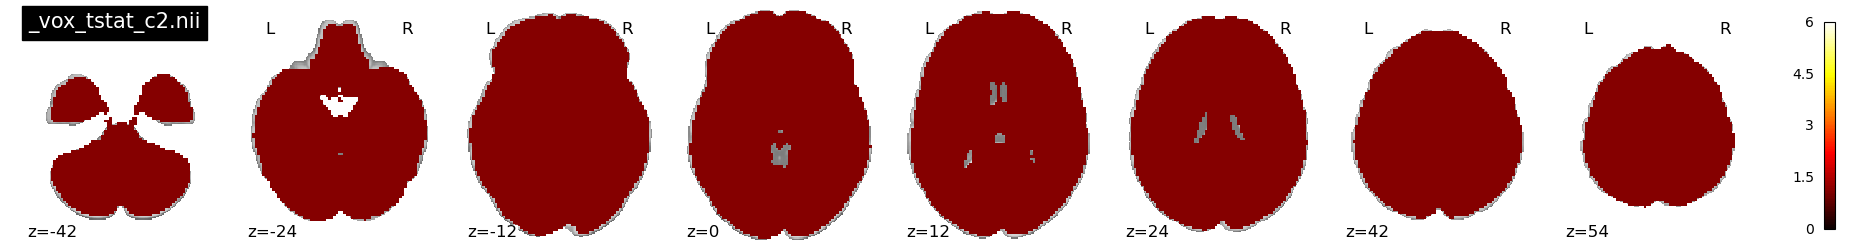

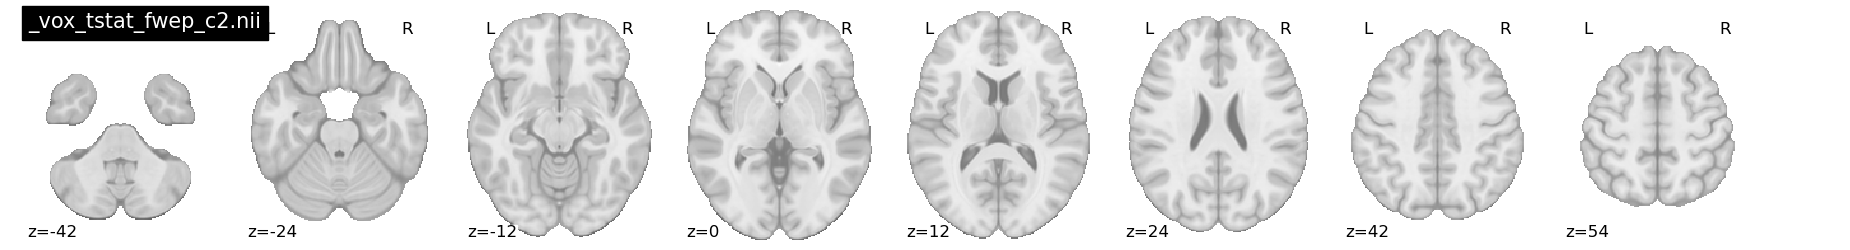

In [35]:
# Function that thresholds Tmaps using a specified p-value map and alpha level
def thresholded_PALM_Tmap(output_dir,tvalue_file='_vox_tstat.nii', pvalue_file='_vox_tstat_fwep.nii', threshold='0.95',showT=False):
    tvalue_map = image.math_img("a*b",a=os.path.join(output_dir,tvalue_file),b=MNI_brain_mask)
    pvalue_map = os.path.join(output_dir,pvalue_file)
    pvalue_mask = image.math_img(f'MNI_brain_mask * img > {threshold}', img=pvalue_map, MNI_brain_mask=MNI_brain_mask)
    combined = image.math_img("a*b",a=tvalue_map,b=pvalue_mask)
    print("There are",np.sum(pvalue_mask.get_fdata()),"non-zero voxels in this maps")
    if showT:
        plotting.plot_stat_map(tvalue_map, 
                display_mode="z", cut_coords=[-42,-24,-12,0,12,24,42,54], cmap="cold_hot", colorbar=True, title=tvalue_file, vmax=6)
    plotting.plot_stat_map(combined, 
                display_mode="z", cut_coords=[-42,-24,-12,0,12,24,42,54], cmap="cold_hot", colorbar=True,title=pvalue_file, vmax=6)

    
print("FWE")
thresholded_PALM_Tmap(output_dir,tvalue_file='_vox_tstat_c2.nii', pvalue_file='_vox_tstat_fwep_c2.nii', threshold='0.95',showT=True)

print("FDR")
thresholded_PALM_Tmap(output_dir,tvalue_file='_vox_tstat.nii', pvalue_file='_vox_tstat_fdrp.nii', threshold='0.95')

print("uncorrected")
thresholded_PALM_Tmap(output_dir,tvalue_file='_vox_tstat.nii', pvalue_file='_vox_tstat_uncp.nii', threshold='0.95')

# print("TFCE FWE")
# thresholded_PALM_Tmap(output_dir,tvalue_file='_tfce_tstat.nii', pvalue_file='_tfce_tstat_fwep.nii', threshold='0.95')

Clean Up

In [ ]:
# Clean up the big temporary file to keep result directories small:
try:
    os.remove(os.path.join(working_dir,'concat.nii'))
except:
    print('No concat file to delete.')